# Demonstration: Euler-Maruyama Method for SDEs using PyTorch CUDA


In [31]:
import torch, math
import matplotlib.pyplot as plt

#### We have the general form for an **Itô Stochastic Differential Equation (SDE)**:

$$dX_t=f(t,X_t)dt+g(t,X_t)dW_t$$

$X_t \in \mathbb{R}^{d}$: multidimensional state vector

$f(t,X_t)$: drift term, the deterministic evolution

$g(t,X_t)$: diffusion term, the noise intensity

$W_t$: the weiner process (Brownian motion), or a random path with $W_{t+\Delta t} - W_t \sim \mathcal{N}(0, \Delta t)$ 

#### With a **discrete time grid** $t_0,t_1,...,t_N$, we can approximate a solution rather than analytical integration.
The **Euler-Maruyama** method, an extension of the Euler method for ODEs can be described as:

$$X_{k+1} = X_k + f(t_k, X_k)\Delta t + g(t_k, X_k)\Delta W_k$$

Like non-stochastic numerical methods, this describes the next timestep.

In accordance with standard statistical notation, a Geometric Brownian motion can be simulated using increments 
$$\Delta {X_t} \sim \mathcal{N}(\mu\Delta t, \sigma^2 \Delta t)$$ 

by setting :

$$f(t,X_t)=\mu, g(t,X_t) = \sigma$$

In [32]:
def f(t, x, p): return p["mu"] * x    # drift function
def g(t, x, p): return p["sigma"] * x # diffusion function

def sdeint_euler(f, g, y0, t, params, generator=None):

    y = y0.clone() # initial state
    B, d = y.shape # batch size, state dimension
    T = len(t)     # time domain
    traj = torch.empty((T, B, d), device=y.device, dtype=y.dtype) # preallocate trajectory data
    traj[0] = y    # initial state into tensor

    for k in range(T - 1):
        dt = t[k+1] - t[k]       # time increment
        dW = torch.randn(B, d, device=y.device, generator=generator) * torch.sqrt(dt) # given dW = sqrt(dt) * N(0,1)
        ftk = f(t[k], y, params) # drift increment (deterministic)
        gtk = g(t[k], y, params) # diffusion increment (stochastic)
        y = y + ftk*dt + gtk*dW  # Euler-Maruyama update
        traj[k+1] = y
    return traj


Let's view the sample case where $[\mu, \sigma] = [0.2, 0.5]$ on a batch size of $B=8192$.

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Will test for Pytorch's built-in CUDA compiler and run simulations in parallel if available
B, d = 8192, 1                                          # batch size, state dimension
T = 1
t = torch.linspace(0, T, 512, device=device)            # time domain
y0 = torch.ones(B, d, device=device)                    # initial state
params = {"mu": 0.2, "sigma": 0.5}                      # SDE parameters
gen = torch.Generator(device=device).manual_seed(0)     # random seed

In [34]:
traj = sdeint_euler(f, g, y0, t, params, generator=gen) # solve SDE

Let's plot some of our trajectories.

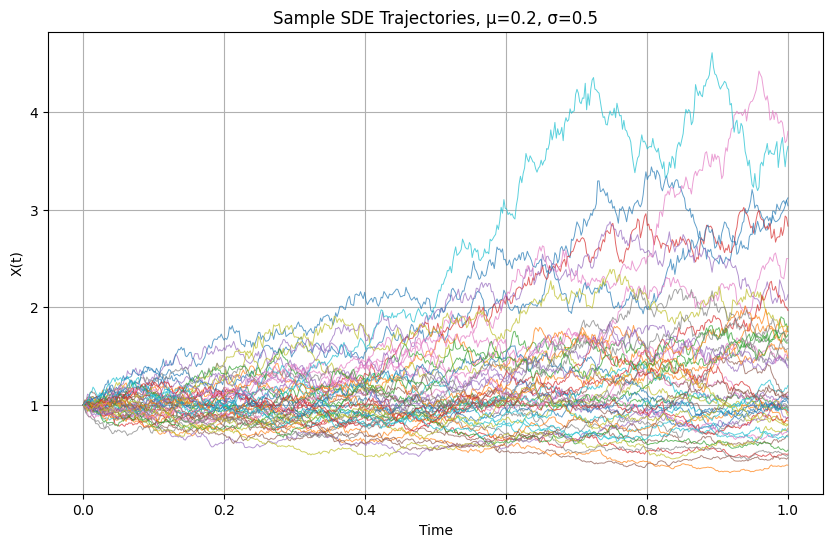

In [35]:
plt.figure(figsize=(10,6))

for i in range(min(50, B)):
    plt.plot(t.cpu(), traj[:, i, 0].cpu(), lw=0.7, alpha=0.7)

plt.title(f"Sample SDE Trajectories, μ={params['mu']}, σ={params['sigma']}")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.grid(True)
plt.show()

We can also extract data, such as the set of final states $x_T$, as well as its empirical mean and variance.

One way to verify our solver is to compare it with the theoretical mean and variance using first and second moments:

$$\mu(t) = \mathbb{E}[X_t] = e^{\mu t}$$

$$\sigma^2(t) = \text{Var}[X_t] = \mathbb{E}[X_t^2] - (\mathbb{E}[X_t])^2$$

For Geometric Brownian Motion:

$$
\mathbb{E}[X_t^2] = e^{2\mu t} \, e^{\sigma^2 t} \quad \text{and} \quad (\mathbb{E}[X_t])^2 = e^{2 \mu t}$$

$$
\Rightarrow \sigma^2(t) = e^{2\mu t} \left( e^{\sigma^2 t} - 1 \right)
$$

In [36]:
xT = traj[-1]                                           # extract final states
mean_emp = xT.mean().item()                             # empirical mean
var_emp = xT.var(unbiased=False).item()                 # empirical variance

In [37]:
mean_th = math.exp(params["mu"] * T)
var_th = math.exp(2*params["mu"]*T) * (math.exp(params["sigma"]**2*T) - 1)
print(f"mean sim={mean_emp:.4f}, theory={mean_th:.4f}")
print(f"var  sim={var_emp:.4f}, theory={var_th:.4f}")

mean sim=1.2180, theory=1.2214
var  sim=0.4144, theory=0.4237


Let's see how close they are to the theoretical metrics.

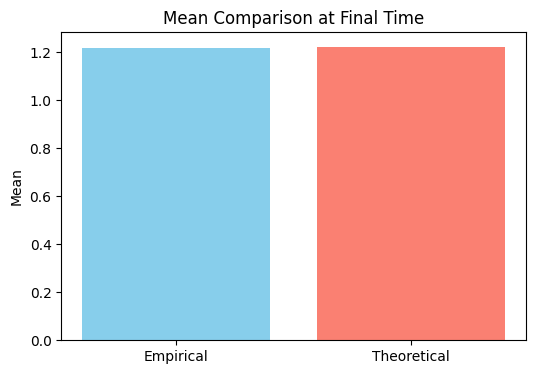

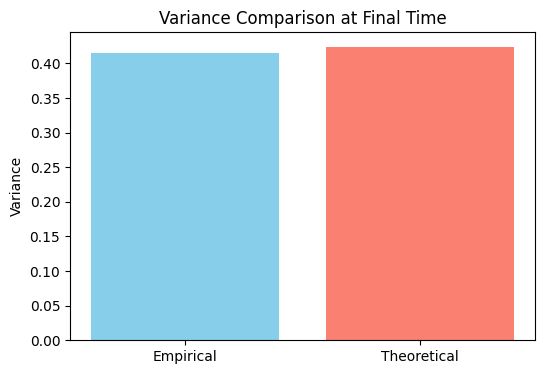

In [38]:
# empirical vs theoretical mean
plt.figure(figsize=(6,4))
plt.bar(["Empirical", "Theoretical"], [mean_emp, mean_th], color=["skyblue","salmon"])
plt.title("Mean Comparison at Final Time")
plt.ylabel("Mean")
plt.show()

# empirical vs theoretical variance
plt.figure(figsize=(6,4))
plt.bar(["Empirical", "Theoretical"], [var_emp, var_th], color=["skyblue","salmon"])
plt.title("Variance Comparison at Final Time")
plt.ylabel("Variance")
plt.show()